<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Single-agent-Markov-LLN" data-toc-modified-id="Single-agent-Markov-LLN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Single-agent Markov LLN</a></span><ul class="toc-item"><li><span><a href="#Remove-effect-of-initial-conditions" data-toc-modified-id="Remove-effect-of-initial-conditions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Remove effect of initial conditions</a></span></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualize</a></span></li></ul></li><li><span><a href="#Synthetic-panel-of-households" data-toc-modified-id="Synthetic-panel-of-households-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Synthetic panel of households</a></span></li></ul></div>

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from BewleyAiyagari import Bewley_Aiyagari as bam

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

%matplotlib inline

# Single-agent Markov LLN

Here, we are simulating a partial equilibrium outcome for a single agent, taking price $r$ as given:

In [2]:
# AR(1) shock process to individual skill/productivity
rho = 0.8
sigma = 0.3*np.sqrt(1.-rho**2)

# Instantiate model CLASS on these parameters
wham = bam(a_lb=-2.0, a_ub=40., RHO=rho, SIGMA=sigma, NGRID_e=3)

# Fix arbitrary market relative price, note w = w(r)
r = 0.03414

Solve dynamic program given $r$:

In [3]:
w = wham.CobbDouglas_mpl(r)
params = [r, w]
v, g = wham.Howard(params, display_howard=True)

[ =============== ] 100.00% 21/21, error1 = 0.00009    

Simulate sample path given optimal policy $(a,e) \mapsto g(a,e)$:

In [4]:
apath, epath = wham.MonteCarloSimulation(g, T_sim=50000)

## Remove effect of initial conditions

**Note**: A current agent state is $(a_{t}, e_{t})$.

To ensure we are drawing samples from the ergodic distribution of agent states, we simulate the outcomes for long enough and discard a sufficiently long "burn-in" sample:

In [5]:
T_burn = 20000

apath_burn = apath[T_burn:-1]
apath_burn.size

30000

Likewise for the Markov-chain primitive shock to earnings:

In [6]:
epath_burn = epath[T_burn::]
epath_burn.size

30000

Check that the simulation is representative of the asymptotic distribution:

In [7]:
print("Sample statistics ...\n")

S = wham.S
for idx_e, e in enumerate(S):
    print("Proportion time spent in state %i = %6.2g" 
          %(idx_e, (epath_burn[epath_burn==S[idx_e]]).size/epath_burn.size)
         )

Sample statistics ...

Proportion time spent in state 0 =   0.26
Proportion time spent in state 1 =   0.49
Proportion time spent in state 2 =   0.25


In [8]:
print("Ergodic distribution of earnings shock ...\n")

p_inf = wham.ErgodistMC(wham.P)
for idx_e, prob_e in enumerate(p_inf):
    print("Proportion time spent in state %i = %6.2f" %(idx_e, prob_e))

Ergodic distribution of earnings shock ...

Proportion time spent in state 0 =   0.25
Proportion time spent in state 1 =   0.50
Proportion time spent in state 2 =   0.25


## Visualize

Monte-Carlo sample path of agent asset position:

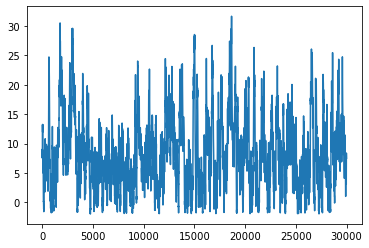

In [9]:
plt.figure()
plt.plot(apath_burn)
plt.show()

Joint distribution of asset positions:

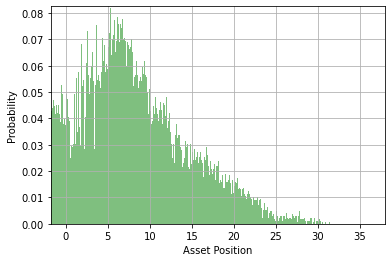

In [10]:
plt.figure()
freq, bins = wham.ShowDistro(apath_burn)
plt.show()

Check to see if there are some who end up borrowing sometimes:

In [11]:
apath_burn[apath_burn<0.0]

array([-0.05878611, -0.28310309, -0.49360476, ..., -0.03116065,
       -0.01831743, -0.00588788])

Sort by states of earnings shock outcome:

There are 7708 people in state e = 0.65
There are 14793 people in state e = 1.00
There are 7499 people in state e = 1.53


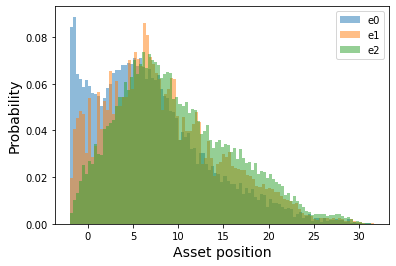

In [12]:
plt.figure()

A_sort_by_e = []

for idx_e, e in enumerate(S):
    # Conditioning on e
    apath_by_e = apath_burn[epath_burn==e]
    A_sort_by_e.append(apath_by_e)
    print("There are %i people in state e = %0.2f" 
          %(apath_by_e.size, e)
         )
    # Histograms - overlapping
    opaquefy = 0.5
    plt.hist(apath_by_e, bins=100, 
             density=True, 
             alpha=opaquefy, 
             label="e"+str(idx_e))
plt.xlabel("Asset position", size=14)
plt.ylabel("Probability", size=14)
plt.legend(loc='upper right')
plt.show()

In [165]:
apath_burn.mean()

8.247581268919328

In [187]:
apath_burn.std()

6.371672794619706

# Synthetic panel of households

In [138]:
def SimulateMarkovChain(S, P, mu=None, T=88888):
        """Simulate T-length observations of Markov chain (mu,P)"""
        """Note: Finite state space Z admit integers or reals"""
        if mu is None:
            # Define arbitrary initial uncond. distro over Z
            mu = np.random.rand(S.size)
            mu = mu/mu.sum()
        data = np.empty(T)
        data[0] = np.random.choice(S, replace=False, p = mu)
        for t in range(T-1):
            # Find index/location of element in Z with value data[t]
            state = S.tolist().index(data[t])
            # Given state index, draw new state from conditional distro
            data[t+1] = np.random.choice(S, replace=False, p = P[state,:])         
        return data

In [139]:
def MonteCarloSimulation(g, a_init, S, P, T_sim=20000):
    a_path = [ a_init ]
    e_path = SimulateMarkovChain(S, P, T=T_sim)
    for t, e in enumerate(e_path):
        # Get index of e in S
        idx_e = S.tolist().index(e)
        # Bounds checking and updating path of a(t)
        if a_path[t] <= asset_grid_fine.min():
            # Po'-rest boy
            a_path.append(g[0, idx_e])
        elif a_path[t] >= asset_grid_fine.max():
            # Rich-est daddy-O
            a_path.append(g[-1, idx_e])
        else:
            # Typical in-betweeners
            astar = np.interp(a_path[t], asset_grid, g[:, idx_e])
#             g_fitted = self.InterpFun1d(asset_grid, g[:, idx_e])
#             astar = g_fitted(a_path[t])
            a_path.append(astar)
    return a_path

Our (earnings-shock) Markov-chain elements:

In [140]:
P = wham.P
S = wham.S

Let's simulate a panel of with time-series length ``T_panel`` and ``N_agents`` number of people initially uniformly distributed in the asset space:

In [179]:
N_agents = 50
T_panel = 10000
asset_grid = wham.asset_grid
asset_grid_fine = np.linspace(wham.a_lb, wham.a_ub, N_agents)

In [180]:
def SimPanel(g, asset_grid_fine, S, P, N_agents, T_panel):
    A_panel = []
    for i in range(N_agents):
        A_panel.append(MonteCarloSimulation(g, asset_grid_fine[i], S, P, T_sim=T_panel))
    return A_panel

In [181]:
AA = SimPanel(g, asset_grid_fine, S, P, N_agents, T_panel)

In [182]:
asset_panel = np.reshape((np.array(AA)).flatten(), (N_agents, T_panel+1))

In [185]:
asset_panel[:,5001::].mean()

8.68527153277315

In [186]:
asset_panel[:,5001::].std()

6.5836661206616744

In [ ]:
plt.figure()
plt.hist(asset_panel[0:10,8001::], bins=100, 
             density=True, 
             alpha=0.5, 
        )
plt.xlabel("Asset position", size=14)
plt.ylabel("Probability", size=14)
plt.show()